In [3]:
# Import all required libraries.
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from PIL import Image
from torchvision.models import vgg11_bn
# torchvision.models.vgg11_bn
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [4]:
# Filter out the warnings.
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Check if CUDA is available.
# If so, assign the device to CUDA.
if torch.cuda.is_available():
    print("CUDA is available on this machine.")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Found CUDA-enabled device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available on this machine.")

CUDA is available on this machine.
Found CUDA-enabled device: NVIDIA GeForce RTX 2060


In [6]:
class TorchVisionDataset(Dataset):
    '''
    Dataset class for handling the input image data.
    '''
    def __init__(self, data_dic, transform=None):
        # Initialize the file paths and labels from the input data dictionary.
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

        # Count for corrupted images.
        self.corrupted_count = 0

    def __len__(self):
        '''
        Returns the total number of samples in the dataset.
        '''
        return len(self.file_paths)

    
    def __getitem__(self, idx):
        '''
        Retrieves an image and its corresponding label from the dataset
        based on a provided index location, idx.
        '''
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        try:
            # Open the image file.
            image = Image.open(file_path)

            # Convert RGBA images to RGB.
            if image.mode == 'RGBA':
                image = image.convert('RGB')
            
            # Apply transformations (if specified).
            if self.transform:
                image = self.transform(image)
            return image, label
        
        except Exception as e:
            # Error handling for corrupted images.
            self.corrupted_count += 1
            print(self.corrupted_count)
            return torch.zeros(3, 224, 224), label

In [7]:
# Load image paths and store in an numpyp array, images.
images = glob.glob("../data/*/*/*")
images = np.array(images)

# Load the corresponding labels by splitting the file path on \ delimiter.
# Take the second from last entry in the array as the label.
labels = np.array([f.split("\\")[-2] for f in images])

# Print the length of the images and labels array.
# Print the first entry of the images and labels array.
print(len(images))
print(labels.size)
print(images[0])
print(labels[0])

8000
8000
../data\test\Bridge\018.jpg
Bridge


In [9]:
# Get all unique classes from the label array.
classes = np.unique(labels).flatten()
print(classes)

# Convert labels to integers.
labels_int = np.zeros(labels.size, dtype=np.int64)
print(labels_int.shape)

# Assign integer labels to each class.
for ii, jj in enumerate(classes):
    labels_int[labels == jj] = ii 

['Bridge' 'Commercial' 'Industrial' 'Intersection' 'Landmark' 'Park'
 'Parking' 'Playground' 'Residential' 'Stadium']
(8000,)


In [10]:
# Iterate through each label and print the total sum
# of samples for each.
for ii in range(len(classes)):
    print("Label ", ii, ":", (labels_int == ii).sum())

Label  0 : 800
Label  1 : 800
Label  2 : 800
Label  3 : 800
Label  4 : 800
Label  5 : 800
Label  6 : 800
Label  7 : 800
Label  8 : 800
Label  9 : 800


In [11]:
# Split the dataset into development and test sets.
# Stratification is used to maintain class distribution for both sets.
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
sss.get_n_splits(images, labels_int)
dev_index, test_index = next(sss.split(images, labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index] 

In [12]:
# Split the development set into training and validation sets.
sss2 = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
sss2.get_n_splits(dev_images, dev_labels)
train_index, val_index = next(sss2.split(dev_images, dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index] 


In [13]:
# Print the size of the train set, validation set, and test set.
print("Train set:", len(train_images))
print("Val set:", len(val_images))
print("Test set:", len(test_images))

Train set: 6480
Val set: 720
Test set: 800


In [14]:
# Combine the images and labels into dictionaries for the training, validation, and testing sets.
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

In [15]:
# Define required transformations.
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [16]:
# Create the training, validation, and testing datasets (with defined transformations)
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

In [17]:
# Create dataloaders for each dataset.
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

In [18]:
def get_dataset_stats(data_loader):
    '''
    Computes overall statistics on a dataset.
    '''
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the statistics.
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [19]:
# Print the mean and standard deviation of the training dataset.
print(get_dataset_stats(trainloader))

(tensor([-0.5162, -0.3514, -0.2517]), tensor([0.6761, 0.6550, 0.6404]))


In [20]:
# Define a batch of data from the dataloader.
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [21]:
# Print the size of the batch.
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


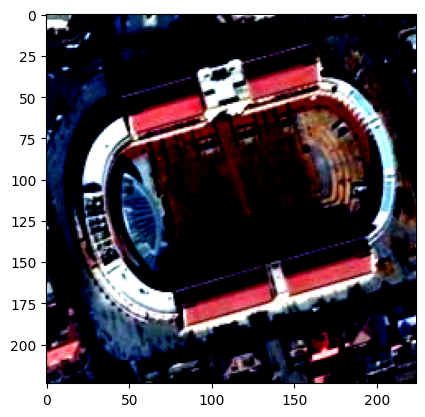

In [22]:
# Show an image from the batch.
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

In [23]:
class Vgg11_BN(nn.Module):
    '''
    Pretrained model to be used for image classification: VGG11_bn
    '''
    def __init__(self, num_classes):
        # Initialize VGG11_bn architecture.
        super(Vgg11_BN, self).__init__()
        self.model = models.vgg11_bn(pretrained=True)
        # Modify the fully connected later to output num_classes.
        num_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_features, num_classes)        
        
    def forward(self, x):
        # Forward pass through the model.
        return self.model(x)

In [24]:
# Initialize the model.
vgg = Vgg11_BN(len(classes))
vgg.to(device)

Vgg11_BN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [25]:
# Count the number of trainable and non-trainable parameters
trainable_params = sum(p.numel() for p in vgg.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in vgg.parameters() if not p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")
print(f"Number of non-trainable parameters: {non_trainable_params}")

Number of trainable parameters: 128812810
Number of non-trainable parameters: 0


In [43]:
# Define the loss function, optimizer, and learning rate scheduler.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [44]:
# Define the number of epochs.
nepochs = 20

# Define the path to save the best model.
PATH = './saved_models/vgg11_bn.pth'

# Initialize the best loss value.
best_loss = 1e+20

# Number of epochs to wait before early stopping.
patience = 5  
count = 0

# Create two lists to store training and validation loss values for each epoch.
train_loss_list = []
val_loss_list = []

# Training Loop.
for epoch in range(nepochs):
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Perform the forward pass.
        outputs = vgg(inputs)
        
        loss = criterion(outputs, labels)

        # Perform the backward pass.
        loss.backward()

        # Perform optimization.
        optimizer.step()

        # Update the training loss.
        train_loss += loss.item()
    
    # Print the results to the display for the specific epoch.
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end=' ')
    train_loss_list.append(train_loss / (i + 1))
    scheduler.step()
    
    # Validation stage.
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels].
            inputs, labels = data[0].to(device), data[1].to(device) 
            outputs = vgg(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i + 1):.3f}')
        val_loss_list.append(val_loss / (i + 1))
        
        # Save the best model.
        if val_loss < best_loss:
            print("Saving model")
            torch.save(vgg.state_dict(), PATH)
            best_loss = val_loss
            count = 0  # Reset count if we found a better model
        else:
            count += 1
            # Early stopping.
            if count >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break
        
print('Finished Training')


1,  train loss: 0.842, val loss: 0.366
Saving model
2,  train loss: 0.263, val loss: 0.301
Saving model
3,  train loss: 0.187, val loss: 0.239
Saving model
4,  train loss: 0.128, val loss: 0.211
Saving model
5,  train loss: 0.101, val loss: 0.229
6,  train loss: 0.078, val loss: 0.219
7,  train loss: 0.072, val loss: 0.213
8,  train loss: 0.057, val loss: 0.206
Saving model
9,  train loss: 0.050, val loss: 0.156
Saving model
10,  train loss: 0.043, val loss: 0.188
11,  train loss: 0.036, val loss: 0.170
12,  train loss: 0.036, val loss: 0.173
13,  train loss: 0.038, val loss: 0.191
14,  train loss: 0.029, val loss: 0.204
Early stopping at epoch 14
Finished Training


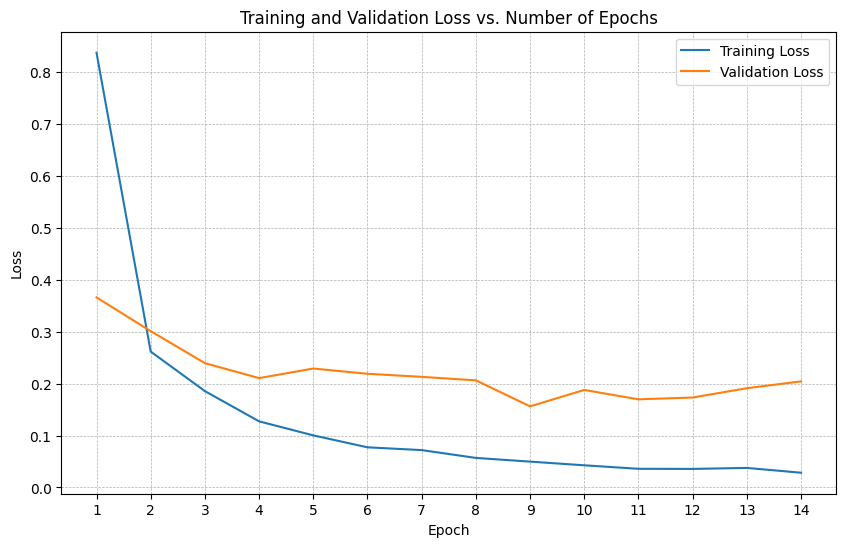

In [45]:
# Graph the train and val loss values over the number of epocse iterations. 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Number of Epochs')
plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.xticks(range(1, len(train_loss_list) + 1))
plt.show()

In [46]:
# Load the best model.
vgg = Vgg11_BN(len(classes))
vgg.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [47]:
# Evaluate the model on the test set.
class_correct = [0 for _ in range(len(classes))]
class_total = [0 for _ in range(len(classes))]
overall_correct = 0
overall_total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network.
        outputs = vgg(images)

        # The class with the highest energy is what we choose as prediction.
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1
            overall_correct += (predicted[i] == label).item()
            overall_total += 1

# Print the accuracy of the network on the test images.
for i in range(len(classes)):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of class {i} - {classes[i]}: {accuracy:.2f} %')

overall_accuracy = 100 * overall_correct / overall_total
print(f'Overall accuracy: {overall_accuracy:.2f} %')


Accuracy of class 0 - Bridge: 100.00 %
Accuracy of class 1 - Commercial: 97.50 %
Accuracy of class 2 - Industrial: 100.00 %
Accuracy of class 3 - Intersection: 98.75 %
Accuracy of class 4 - Landmark: 97.50 %
Accuracy of class 5 - Park: 98.75 %
Accuracy of class 6 - Parking: 100.00 %
Accuracy of class 7 - Playground: 97.50 %
Accuracy of class 8 - Residential: 98.75 %
Accuracy of class 9 - Stadium: 97.50 %
Overall accuracy: 98.62 %


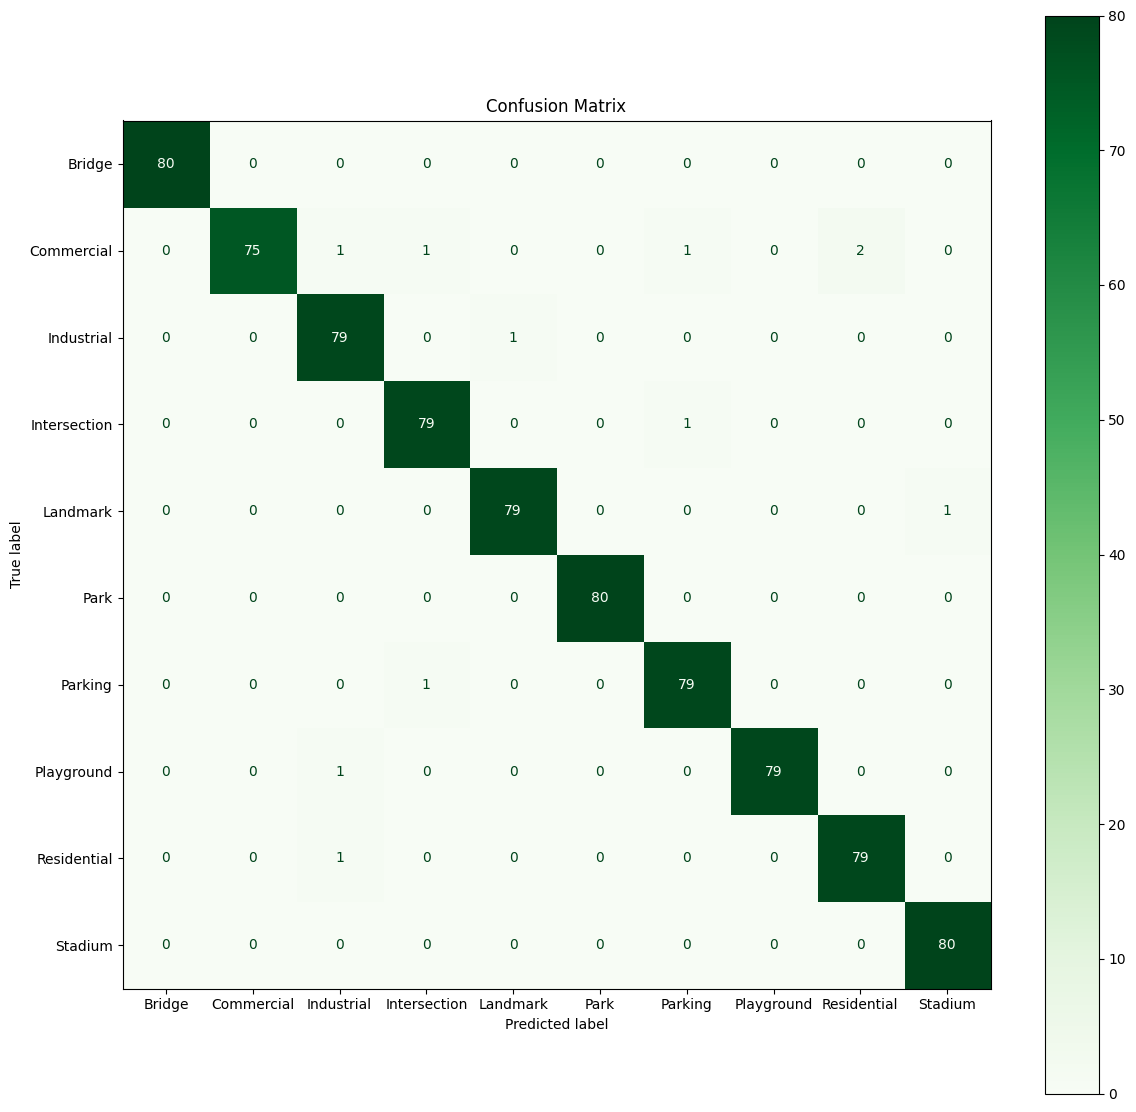

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize variables to store true labels and predicted labels.
true_labels = []
predicted_labels = []

# Since we're not training, we don't need to calculate the gradients for our outputs.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network.
        outputs = vgg(images)
        # The class with the highest energy is what we choose as prediction.
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())


# Calculate the confusion matrix.
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix display.
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)

# Plot the confusion matrix.
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()
